In [1]:
import cv2
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from sklearn.decomposition import PCA


from networkModules.modelUnet3pShort import UNet_3PlusShort
from train_test import make_preRunNecessities

In [2]:
def apply_pca(features):
    # Reshape the tensor to 2D array
    features_2d = features.view(features.shape[0], -1).cpu().numpy()
    
    # Apply PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(features_2d.T).T
    
    # Reshape back to original spatial dimensions but with 3 channels
    pca_result = pca_result.reshape(3, features.shape[1], features.shape[2])
    
    return torch.tensor(pca_result, dtype=torch.float32)



def apply_single_component_pca(features):
    # Reshape the tensor to 2D array
    features_2d = features.view(features.shape[0], -1).cpu().numpy()
    
    # Apply PCA
    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(features_2d.T).T
    
    # Reshape back to original spatial dimensions but with 1 channel
    pca_result = pca_result.reshape(1, features.shape[1], features.shape[2])
    
    return torch.tensor(pca_result, dtype=torch.float32)


In [27]:
def max_pooling(features):
    max_pooled, _ = features.max(dim=0, keepdim=True)
    return torch.cat([max_pooled]*3, dim=0)

def average_pooling(features):
    avg_pooled = features.mean(dim=0, keepdim=True)
    return torch.cat([avg_pooled]*3, dim=0)



# Function to visualize the features
def save_features(features, filename='Outputs/visualization/features.png', conversion_func=average_pooling):
    features = features.cpu()[0]  # Move tensor to CPU and take first batch
    features = conversion_func(features)  # Convert to RGB
    min_val = float(features.min())
    max_val = float(features.max())
    features.clamp_(min=min_val, max=max_val)
    features.add_(-min_val).div_(max_val - min_val + 1e-5)
    out_image = torchvision.utils.make_grid(features.unsqueeze(0), nrow=8)
    plt.imshow(out_image.permute(1, 2, 0).cpu().numpy())  # Convert to numpy array
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)


def save_features_g(features, filename='Outputs/visualization/features.png', conversion_func=average_pooling):
    features = features.cpu()[0]  # Move tensor to CPU and take the first batch
    features = conversion_func(features)  # Convert to single channel using PCA
    min_val = float(features.min())
    max_val = float(features.max())
    features.clamp_(min=min_val, max=max_val)
    features.add_(-min_val).div_(max_val - min_val + 1e-5)
    plt.imshow(features.squeeze().cpu().numpy(), cmap='gray')  # Display in grayscale
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

def save_grayscale_features(features, filename='Outputs/visualization/features.png'):
    features = features.cpu()[0]  # Move tensor to CPU and take the first batch
    avg_pooled = features.mean(dim=0, keepdim=True)  # Average pooling across channels
    min_val = float(avg_pooled.min())
    max_val = float(avg_pooled.max())
    avg_pooled.clamp_(min=min_val, max=max_val)
    avg_pooled.add_(-min_val).div_(max_val - min_val + 1e-5)
    plt.imshow(avg_pooled.squeeze(0), cmap='gray')  # Show as grayscale
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

def save_single_channel(features, channel_index, filename):
    features = features.cpu()[0]  # Move tensor to CPU and take the first batch
    single_channel = features[channel_index, :, :]  # Select the channel
    plt.imshow(single_channel, cmap='gray')  # Show as grayscale
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)


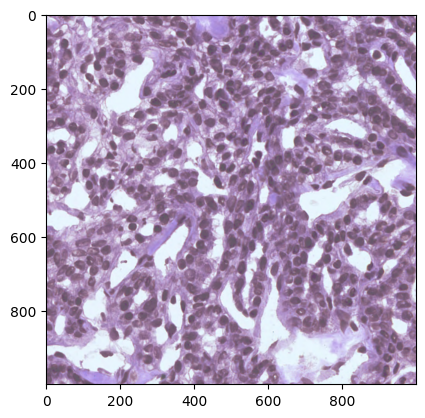

In [28]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# Read the image using OpenCV
image_path = 'Dataset/test_c/0.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

# Preprocess the image
image = cv2.resize(image, (256, 256))
image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
image = image.unsqueeze(0)  # Add a batch dimension
image = image.to(device)

In [29]:

expt_dir = 'Outputs/server1/experiment_09-18_05.12.17/'

config = make_preRunNecessities(expt_dir)
#print("config: ", config)

weight_path = expt_dir + 'model/best_model.pth'
print("weight_path: ", weight_path)

model = UNet_3PlusShort(config)
checkpoint = torch.load(weight_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()




PreRun: Reading config file
PreRun: Creating required directories
Directory log/ already exists
Directory Outputs/experiment_09-18_05.12.17/inference/ already exists
Directory Outputs/experiment_09-18_05.12.17/inference/testData/ already exists
weight_path:  Outputs/server1/experiment_09-18_05.12.17/model/best_model.pth


UNet_3PlusShort(
  (dropout): Dropout2d(p=0.3, inplace=False)
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GLU(dim=1)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GLU(dim=1)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GLU(dim=1)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

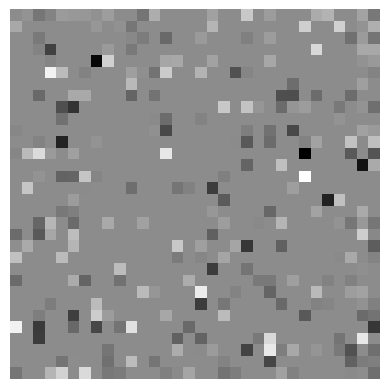

In [30]:
# Register hooks for the layers you want to visualize
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))
model.conv4.register_forward_hook(get_activation('conv4'))

model.conv4d_1.register_forward_hook(get_activation('conv4d_1'))
model.conv3d_1.register_forward_hook(get_activation('conv3d_1'))
model.conv2d_1.register_forward_hook(get_activation('conv2d_1'))
model.outconv1.register_forward_hook(get_activation('outconv1'))

# Forward pass to get the output and populate 'activation'
with torch.no_grad():
    output = model(image)

# Visualize the features
'''save_features(activation['conv1'], 'Outputs/visualization/layer1_v3.png', apply_pca)
save_features(activation['conv2'], 'Outputs/visualization/layer2_v3.png', apply_pca)
save_features(activation['conv3'], 'Outputs/visualization/layer3_v3.png', apply_pca)
save_features(activation['conv4'], 'Outputs/visualization/layer4_v3.png', apply_pca)
save_features(activation['conv4d_1'], 'Outputs/visualization/layer4d_1_v3.png', apply_pca)
save_features(activation['conv3d_1'], 'Outputs/visualization/layer3d_1_v3.png', apply_pca)
save_features(activation['conv2d_1'], 'Outputs/visualization/layer2d_1_v3.png', apply_pca)
save_features(activation['outconv1'], 'Outputs/visualization/layer_outconv1_v3.png', apply_pca)'''


# Visualize the features
'''save_features_g(activation['conv1'], 'Outputs/visualization/layer1_v3.png', apply_single_component_pca)
save_features_g(activation['conv2'], 'Outputs/visualization/layer2_v3.png', apply_single_component_pca)
save_features_g(activation['conv3'], 'Outputs/visualization/layer3_v3.png', apply_single_component_pca)
save_features_g(activation['conv4'], 'Outputs/visualization/layer4_v3.png', apply_single_component_pca)
save_features_g(activation['conv4d_1'], 'Outputs/visualization/layer4d_1_v3.png', apply_single_component_pca)
save_features_g(activation['conv3d_1'], 'Outputs/visualization/layer3d_1_v3.png', apply_single_component_pca)
save_features_g(activation['conv2d_1'], 'Outputs/visualization/layer2d_1_v3.png', apply_single_component_pca)
save_features_g(activation['outconv1'], 'Outputs/visualization/layer_outconv1_v3.png', apply_single_component_pca)'''

'''save_grayscale_features(activation['conv1'], 'Outputs/visualization/layer1_v4.png')
save_grayscale_features(activation['conv2'], 'Outputs/visualization/layer2_v4.png')
save_grayscale_features(activation['conv3'], 'Outputs/visualization/layer3_v4.png')
save_grayscale_features(activation['conv4'], 'Outputs/visualization/layer4_v4.png')
save_grayscale_features(activation['conv4d_1'], 'Outputs/visualization/layer4d_1_v4.png')
save_grayscale_features(activation['conv3d_1'], 'Outputs/visualization/layer3d_1_v4.png')
save_grayscale_features(activation['conv2d_1'], 'Outputs/visualization/layer2d_1_v4.png')
save_grayscale_features(activation['outconv1'], 'Outputs/visualization/layer_outconv1_v4.png')'''

f_channel = [32, 64, 128, 128]
for layer in [1, 2, 3, 4]:
    for channel in range(f_channel[layer-1]):
        save_single_channel(activation['conv%d' % layer], channel, 'Outputs/visualization/all_features/layer%d/layer%d_fc_%d.png' % (layer, layer, channel))


In [6]:
print("Model's device:", next(model.parameters()).device)
print("Input's device:", image.device)


Model's device: cuda:0
Input's device: cuda:0
